In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud

In [6]:
# Run the utilty functions from the seperate notebook
%run topic_utils.ipynb

In [7]:
# Define some constants
INPUT_FILE_NAME = 'outputFrance.csv'

MIN_DF = 3
MAX_DF = 0.85
MAX_NUM_FEATURES = 20000

K_RANGE = list(np.arange(2, 20, 2))

CUSTOM_STOP_WORDS = ['said', 'say', 'says,' '...', 'like', 'cent', 'percent', 'ft', 'ms', 'mr', 'month', 'week', 'year', 'bn', 'www', 'com', 'just']
STOP_WORDS = ENGLISH_STOP_WORDS.union(CUSTOM_STOP_WORDS)

N_TOP_WORDS = 20

In [8]:
df = pd.read_csv(INPUT_FILE_NAME)
df['processed_text'] = df['text'].apply(process_text(STOP_WORDS))
print(df.shape)
df.head()

(1807, 5)


,uuid,date,annotations,text,processed_text
0,f6104b22-75b5-35bf-9c62-534d9df19eb2,2017-01-04 09:15:57,IHS Markit Ltd European Central Bank France Gl...,Germany’s powerhouse manufacturing sector was...,"[germany, powerhouse, manufacturing, sector, e..."
1,cdd019d7-3fc2-4c68-ac43-b977f2db851e,2021-02-16 17:13:42,Sub-Saharan Africa Burkina Faso Le Point Franc...,Emmanuel Macron has decided against an immedia...,"[emmanuel, macron, decided, immediate, reducti..."
2,e72a33f0-a225-41ed-9553-2aeec59f0233,2019-09-08 15:01:57,Hunting PLC Paris travel Henri Cartier-Bresson...,“My weekends are hyperactive – with or without...,"[weekends, hyperactive, kids, saturdays, invol..."
3,f9920a26-6750-11e9-9adc-98bf1d35a056,2019-04-26 04:01:23,Organisation for Economic Co-operation & Devel...,French workers pride themselves on being more ...,"[french, workers, pride, productive, peers, co..."
4,1157896c-8817-4d3c-a63c-e59f2752aaac,2021-01-11 11:00:04,ByteDance Brits UK France BioNTech Louis Paste...,The writer is a researcher at the Institute fo...,"[writer, researcher, institute, strategic, dia..."


In [9]:
# Get the top 20 most common words among all the articles
p_text = [item for sublist in df['processed_text'] for item in sublist]
df_top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

df_top_20

,word,frequency
0,france,5279
1,french,4762
2,macron,3317
3,eu,2113
4,european,1995
5,president,1780
6,new,1772
7,government,1741
8,paris,1480
9,people,1446


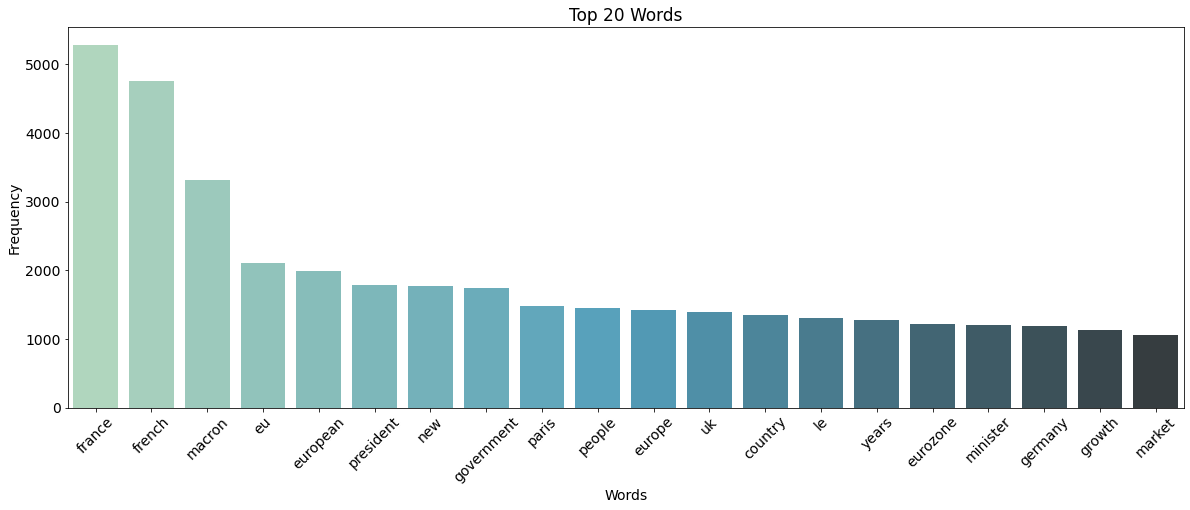

In [10]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=df_top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

# fig.savefig('top20words.png', dpi=fig.dpi, bbox_inches='tight')

plt.show()

In [11]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

34004

In [12]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=MIN_DF,
    no_above=MAX_DF,
    keep_n=MAX_NUM_FEATURES
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

In [13]:
# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in K_RANGE:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

In [15]:
# Get the number of topics with the highest coherence score
scores = list(zip(K_RANGE, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
print(best_num_topics)

16


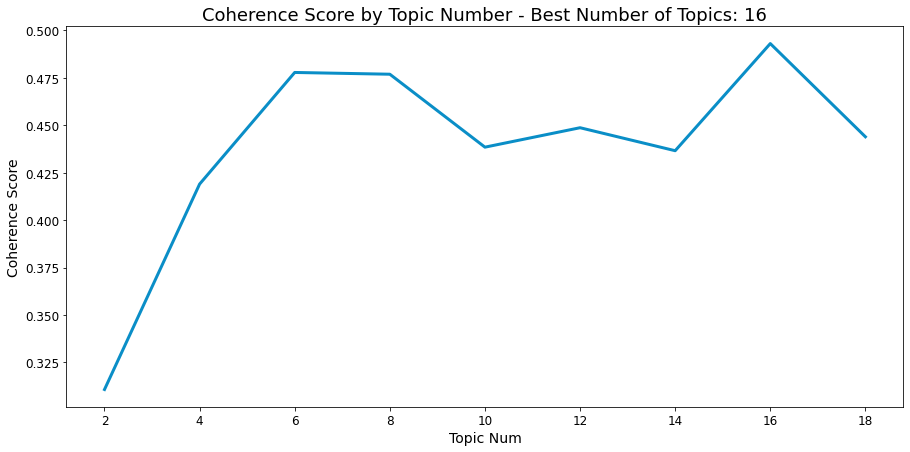

In [16]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    K_RANGE,
    coherence_scores,
    linewidth=3,
    color='#0a8ec7'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(min(K_RANGE), max(K_RANGE) + 1, 2), fontsize=12)
plt.yticks(fontsize=12)

# fig.savefig('coherence.png', dpi=fig.dpi, bbox_inches='tight')

plt.show()

In [17]:
first_best_k = [ topic_num for (topic_num, coh_val) in sorted(scores, key=itemgetter(1), reverse=True)]
first_best_k[:3]
print(f'First 3 best number of topics by coherence score: {first_best_k[:3]}')

First 3 best number of topics by coherence score: [16, 6, 8]


In [18]:
# IMPORTANT: Choose automatically the best number of topics from best_num_topics or analyze the graphic above
best_num_topics = 16

In [19]:
# Use the number of topics with the highest coherence score to run the sklearn nmf model

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=MIN_DF,
    max_df=MAX_DF,
    max_features=MAX_NUM_FEATURES,
    ngram_range=(1, 2),
    preprocessor=' '.join,
    stop_words=STOP_WORDS
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [20]:
# Find the top words for each cluster by tfidf weight to create 'topics'
topics = {}
for topic_idx, topic in enumerate(nmf.components_):
    topics[topic_idx] = [tfidf_fn[i] for i in topic.argsort()[:-N_TOP_WORDS - 1:-1]]

topic_df = pd.DataFrame(topics)
topic_df_transposed = topic_df.transpose()
topic_df_transposed.head(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,gilets,jaunes,gilets jaunes,macron,protests,police,protesters,government,fuel,saturday,movement,paris,people,french,anti,violence,demonstrations,president,protest,demonstrators
1,quarter,growth,eurozone,economy,gdp,second,second quarter,months,household,industrial,spending,grew,output,forecast,economic,french economy,previous,production,data,country
2,bond,debt,bonds,yields,investors,points,yield,eurozone,basis points,basis,bank,euro,bps,markets,french,german,market,country,central,risk
3,sales,group,casino,carrefour,company,market,executive,chief executive,chief,revenues,retailer,shares,altice,quarter,business,investment,performance,profit,share,growth
4,eu,european,brexit,europe,german,merkel,uk,macron,germany,brussels,eurozone,commission,budget,states,deal,countries,britain,berlin,member,leaders
5,markit,ihs,ihs markit,manufacturing,sector,growth,pmi,index,reading,activity,services,output,purchasing managers,purchasing,expansion,surveys,business,eurozone,survey,managers
6,people,coronavirus,vaccine,covid,health,lockdown,virus,pandemic,cases,restrictions,countries,uk,infections,vaccines,astrazeneca,country,spain,new,number,patients
7,renault,nissan,ghosn,alliance,carmaker,renault nissan,japanese,board,french,fca,senard,merger,carlos ghosn,carlos,mitsubishi,state,company,arrest,le maire,maire
8,tax,digital,companies,tech,google,oecd,profits,amazon,trade,tariffs,french,digital tax,apple,maire,le maire,taxes,facebook,technology,levy,countries
9,index,uk,calendar,london,futures,economic calendar,kong,hang seng,seng,futures tip,hong,hong kong,hang,tip,times london,topix,tip ftse,ftse,asia,open


In [21]:
# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

df['topic_num'] = docweights.argmax(axis=1)
df.head()

,uuid,date,annotations,text,processed_text,topic_num
0,f6104b22-75b5-35bf-9c62-534d9df19eb2,2017-01-04 09:15:57,IHS Markit Ltd European Central Bank France Gl...,Germany’s powerhouse manufacturing sector was...,"[germany, powerhouse, manufacturing, sector, e...",5
1,cdd019d7-3fc2-4c68-ac43-b977f2db851e,2021-02-16 17:13:42,Sub-Saharan Africa Burkina Faso Le Point Franc...,Emmanuel Macron has decided against an immedia...,"[emmanuel, macron, decided, immediate, reducti...",4
2,e72a33f0-a225-41ed-9553-2aeec59f0233,2019-09-08 15:01:57,Hunting PLC Paris travel Henri Cartier-Bresson...,“My weekends are hyperactive – with or without...,"[weekends, hyperactive, kids, saturdays, invol...",6
3,f9920a26-6750-11e9-9adc-98bf1d35a056,2019-04-26 04:01:23,Organisation for Economic Co-operation & Devel...,French workers pride themselves on being more ...,"[french, workers, pride, productive, peers, co...",13
4,1157896c-8817-4d3c-a63c-e59f2752aaac,2021-01-11 11:00:04,ByteDance Brits UK France BioNTech Louis Paste...,The writer is a researcher at the Institute fo...,"[writer, researcher, institute, strategic, dia...",6


Text(0.5, 1.0, 'Segregation of Topic Clusters over Time')

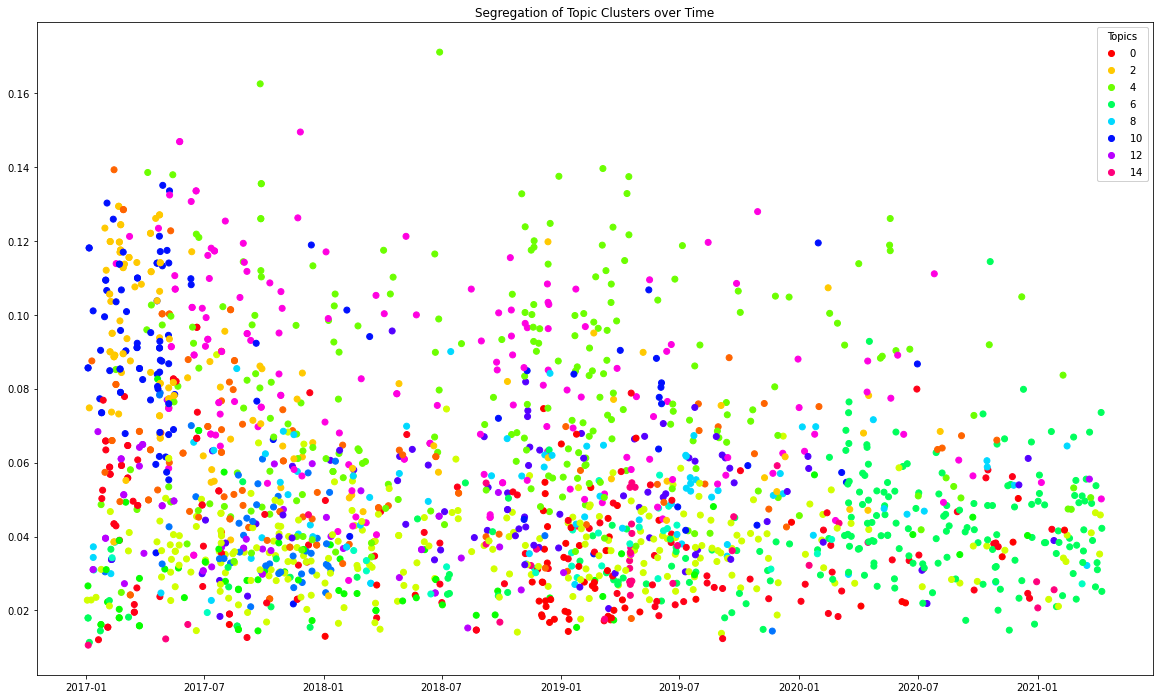

In [22]:
# Plot the clusters on graphis with axis date of the article and component found by SVD
svd_model = TruncatedSVD(n_components=1)
output_svd = svd_model.fit_transform(docweights)
y = output_svd[:,0]

df['date_time'] = pd.to_datetime(df['date'])
dates = [d for d in df['date_time']]

fig, ax = plt.subplots(figsize=(20, 12))

scatter = ax.scatter(dates, y, c=df['topic_num'], cmap='hsv')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Topics")
ax.add_artist(legend)

plt.title("Segregation of Topic Clusters over Time", )

Text(0.5, 1.0, 'Segregation of Topic Clusters over Components')

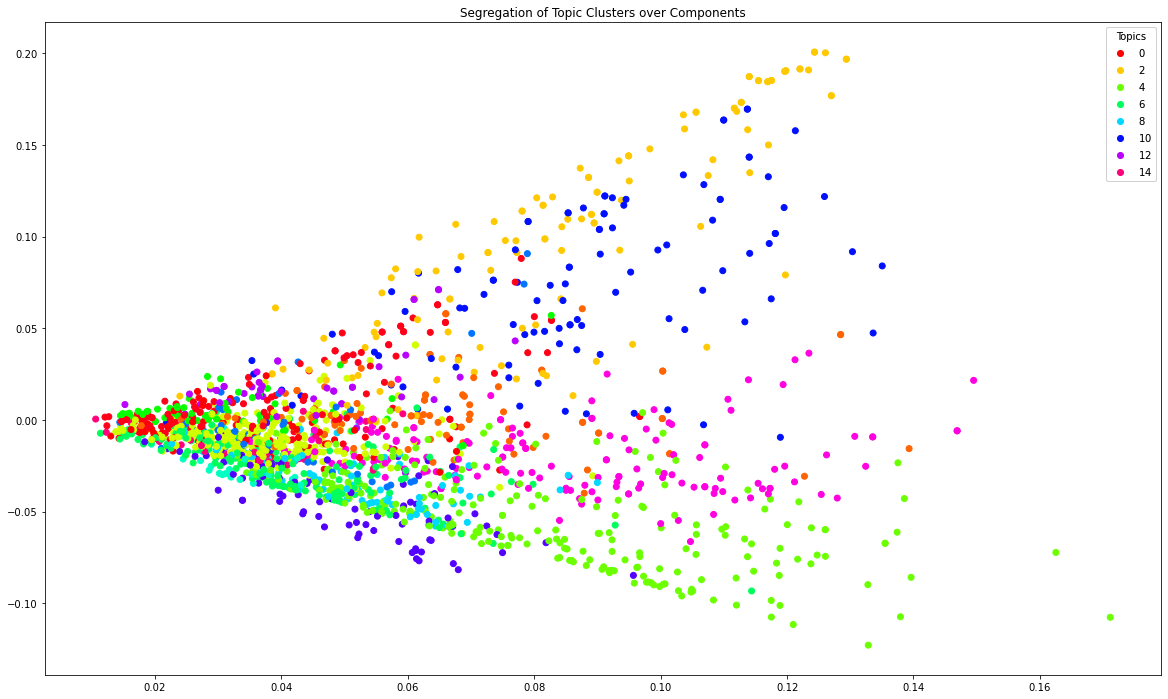

In [23]:
# Plot the clusters on graphis with axis two components found by SVD
svd_model_2 = TruncatedSVD(n_components=2)
output_svd_2 = svd_model_2.fit_transform(docweights)
x_2 = output_svd_2[:,0]
y_2 = output_svd_2[:,1]


# Plot
fig, ax = plt.subplots(figsize=(20, 12))
scatter = ax.scatter(x_2, y_2, c=df['topic_num'], cmap='hsv')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Topics")
ax.add_artist(legend)
plt.title("Segregation of Topic Clusters over Components", )

In [24]:
topic_df_transposed.head(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,gilets,jaunes,gilets jaunes,macron,protests,police,protesters,government,fuel,saturday,movement,paris,people,french,anti,violence,demonstrations,president,protest,demonstrators
1,quarter,growth,eurozone,economy,gdp,second,second quarter,months,household,industrial,spending,grew,output,forecast,economic,french economy,previous,production,data,country
2,bond,debt,bonds,yields,investors,points,yield,eurozone,basis points,basis,bank,euro,bps,markets,french,german,market,country,central,risk
3,sales,group,casino,carrefour,company,market,executive,chief executive,chief,revenues,retailer,shares,altice,quarter,business,investment,performance,profit,share,growth
4,eu,european,brexit,europe,german,merkel,uk,macron,germany,brussels,eurozone,commission,budget,states,deal,countries,britain,berlin,member,leaders
5,markit,ihs,ihs markit,manufacturing,sector,growth,pmi,index,reading,activity,services,output,purchasing managers,purchasing,expansion,surveys,business,eurozone,survey,managers
6,people,coronavirus,vaccine,covid,health,lockdown,virus,pandemic,cases,restrictions,countries,uk,infections,vaccines,astrazeneca,country,spain,new,number,patients
7,renault,nissan,ghosn,alliance,carmaker,renault nissan,japanese,board,french,fca,senard,merger,carlos ghosn,carlos,mitsubishi,state,company,arrest,le maire,maire
8,tax,digital,companies,tech,google,oecd,profits,amazon,trade,tariffs,french,digital tax,apple,maire,le maire,taxes,facebook,technology,levy,countries
9,index,uk,calendar,london,futures,economic calendar,kong,hang seng,seng,futures tip,hong,hong kong,hang,tip,times london,topix,tip ftse,ftse,asia,open


In [25]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 1807 x 20000
W = 16 x 20000
H = 1807 x 16


In [26]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

df['resid'] = r

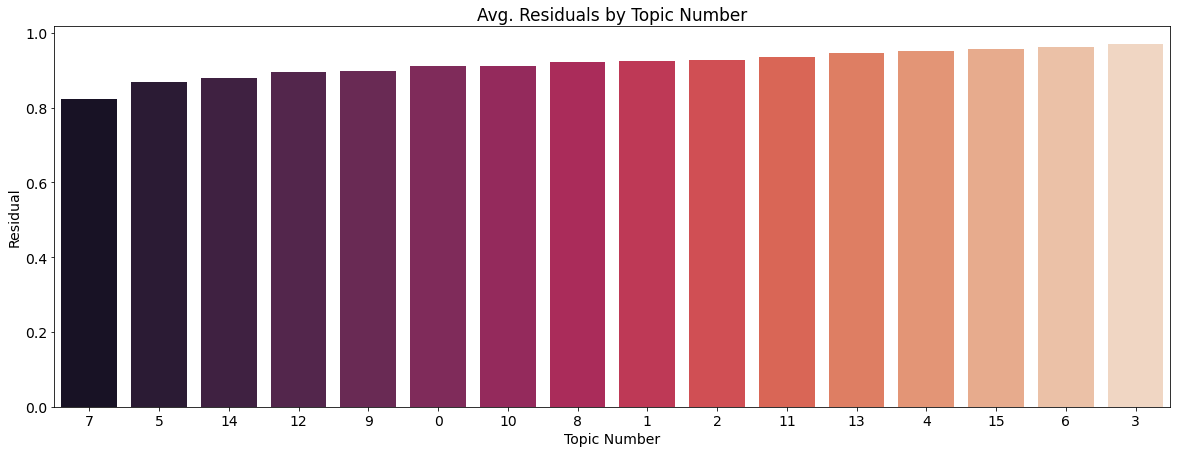

In [27]:
# Get the avg residual by topic
df_residual = df[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = df_residual.index
y = df_residual['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)

file_name = 'avg_resid'

#fig.savefig('resid.png', dpi=fig.dpi, bbox_inches='tight')

plt.show()

In [28]:
# IMPORTANT: choose which cluster to display
DISPLAY_TOPIC_NUM = 7

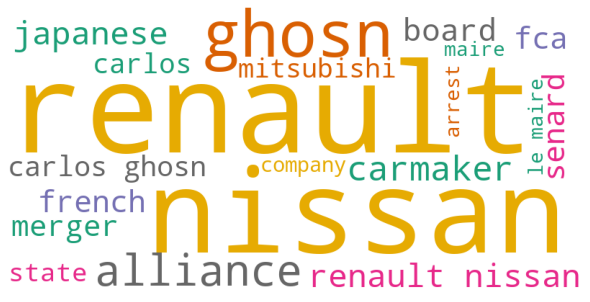

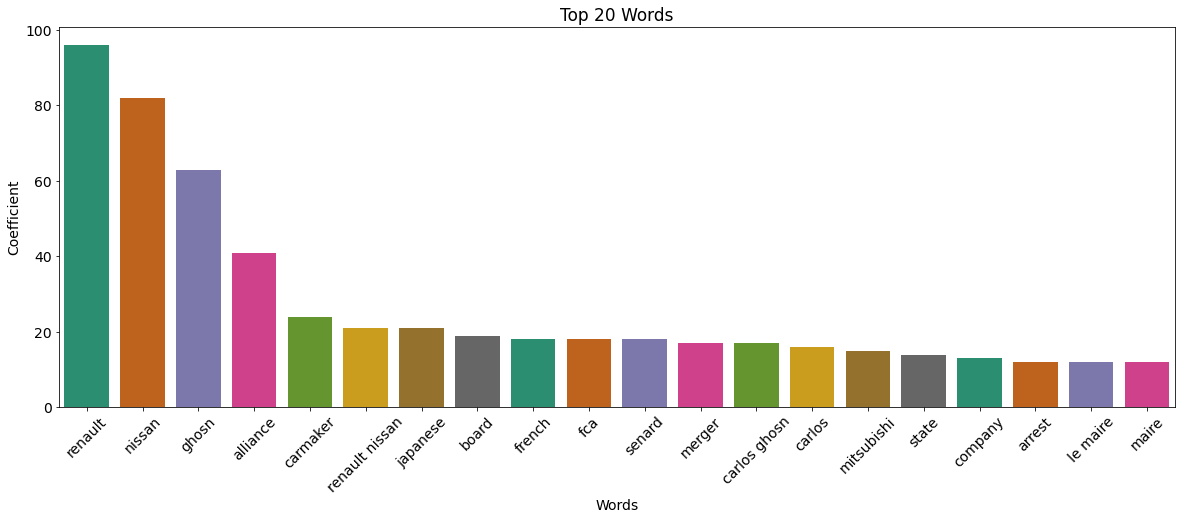

In [29]:
# Display wordcloud and word chart for the topics with best residual

word_dict = {}
for topic_idx, topic in enumerate(nmf.components_):
    word_dict[topic_idx] = {tfidf_fn[i]:int(100*topic[i]) for i in topic.argsort()[:-N_TOP_WORDS - 1:-1]}

for topic_num in [DISPLAY_TOPIC_NUM]:
    wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white', colormap = 'Dark2',
                min_font_size = 10).generate_from_frequencies(word_dict[topic_num])
  
    # plot the WordCloud image                       
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
  
    plt.show()
    
    df_gr = pd.DataFrame.from_dict({"word":list(word_dict[topic_num].keys()), "coefficient":list(word_dict[topic_num].values())})
    # Plot a bar chart for the top 20 most frequently occuring words
    fig = plt.figure(figsize=(20,7))

    g = sns.barplot(
        x='word',
        y='coefficient',
        data=df_gr,
        palette='Dark2'
    )

    g.set_xticklabels(
        g.get_xticklabels(),
        rotation=45,
        fontsize=14
    )

    plt.yticks(fontsize=14)
    plt.xlabel('Words', fontsize=14)
    plt.ylabel('Coefficient', fontsize=14)
    plt.title('Top 20 Words', fontsize=17)

    plt.show()
    

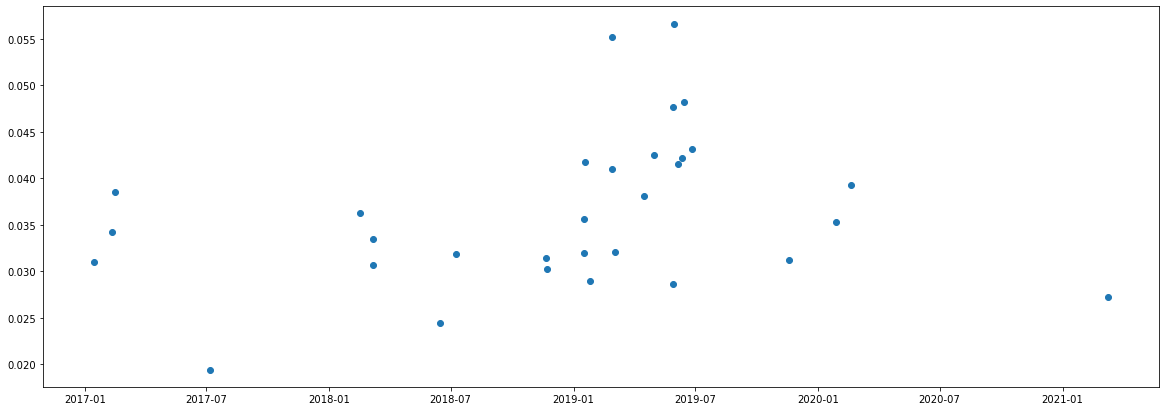

In [30]:
topic_dates = [d for d in df[df['topic_num'] == DISPLAY_TOPIC_NUM]['date_time']]

y = output_svd[:,0]
topic_y = []
for i in list(df.index[df['topic_num'] == DISPLAY_TOPIC_NUM]):
    topic_y.append(y[i])
    
fig = plt.figure(figsize=(20,7))
plt.scatter(topic_dates, topic_y)
plt.show()

In [31]:
# IMPORTANT: choose which cluster to display
DISPLAY_TOPIC_NUM = 10

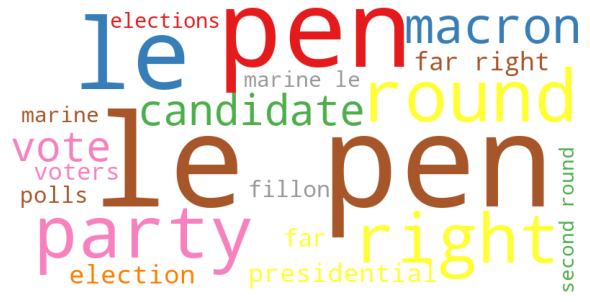

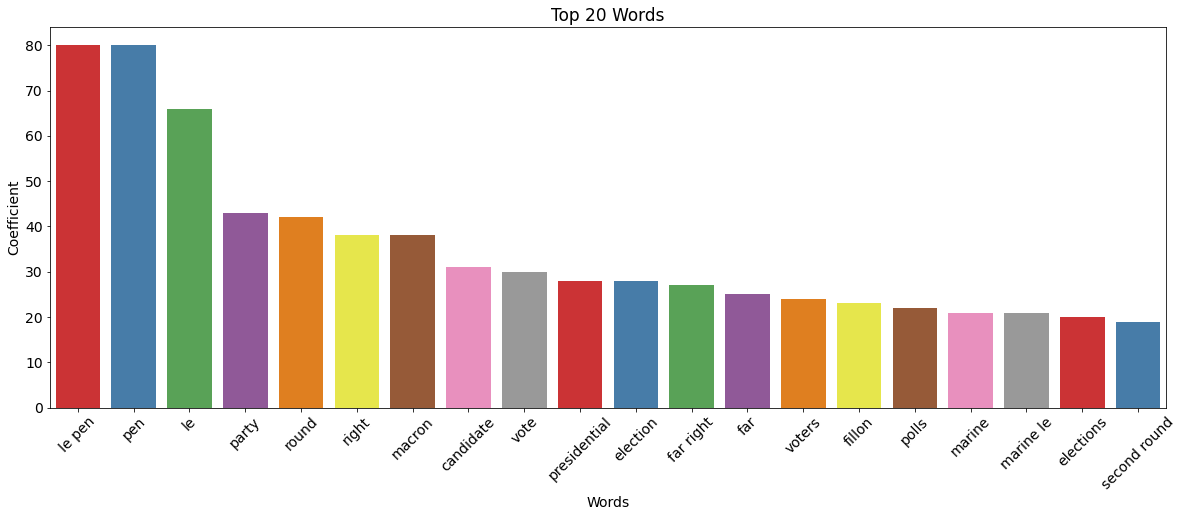

In [32]:
# Display wordcloud and word chart for the topics with best residual

word_dict = {}
for topic_idx, topic in enumerate(nmf.components_):
    word_dict[topic_idx] = {tfidf_fn[i]:int(100*topic[i]) for i in topic.argsort()[:-N_TOP_WORDS - 1:-1]}

for topic_num in [DISPLAY_TOPIC_NUM]:
    wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white', colormap = 'Set1',
                min_font_size = 10).generate_from_frequencies(word_dict[topic_num])
  
    # plot the WordCloud image                       
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
  
    plt.show()
    
    df_gr = pd.DataFrame.from_dict({"word":list(word_dict[topic_num].keys()), "coefficient":list(word_dict[topic_num].values())})
    # Plot a bar chart for the top 20 most frequently occuring words
    fig = plt.figure(figsize=(20,7))

    g = sns.barplot(
        x='word',
        y='coefficient',
        data=df_gr,
        palette='Set1'
    )

    g.set_xticklabels(
        g.get_xticklabels(),
        rotation=45,
        fontsize=14
    )

    plt.yticks(fontsize=14)
    plt.xlabel('Words', fontsize=14)
    plt.ylabel('Coefficient', fontsize=14)
    plt.title('Top 20 Words', fontsize=17)

    plt.show()
    

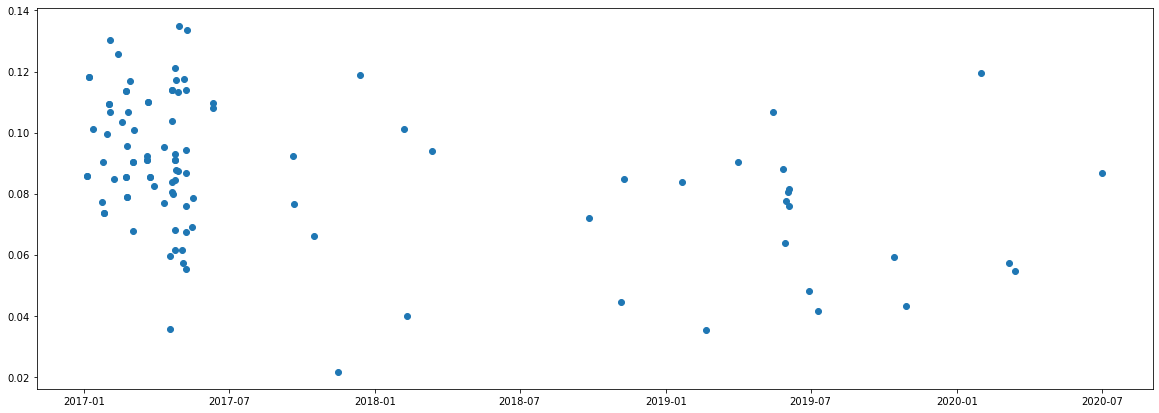

In [33]:
topic_dates = [d for d in df[df['topic_num'] == DISPLAY_TOPIC_NUM]['date_time']]

topic_y = []
for i in list(df.index[df['topic_num'] == DISPLAY_TOPIC_NUM]):
    topic_y.append(y[i])

fig = plt.figure(figsize=(20,7))
plt.scatter(topic_dates, topic_y)
plt.show()

In [34]:
# IMPORTANT: choose which cluster to display
DISPLAY_TOPIC_NUM = 14


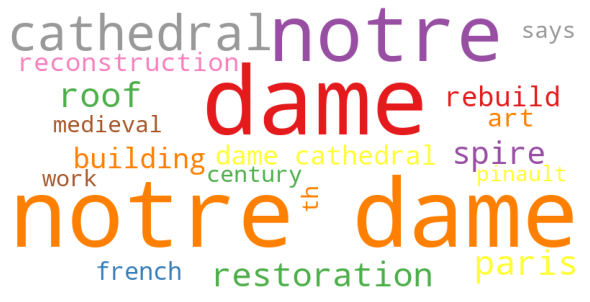

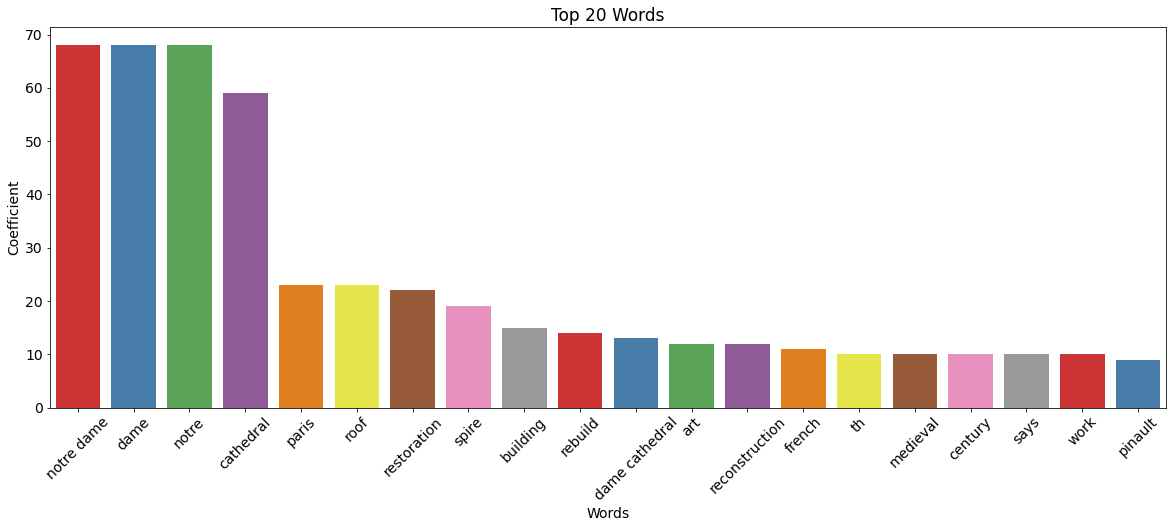

In [35]:
# Display wordcloud and word chart for the topics with best residual

word_dict = {}
for topic_idx, topic in enumerate(nmf.components_):
    word_dict[topic_idx] = {tfidf_fn[i]:int(100*topic[i]) for i in topic.argsort()[:-N_TOP_WORDS - 1:-1]}

for topic_num in [DISPLAY_TOPIC_NUM]:
    wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white', colormap = 'Set1',
                min_font_size = 10).generate_from_frequencies(word_dict[topic_num])
  
    # plot the WordCloud image                       
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
  
    plt.show()
    
    df_gr = pd.DataFrame.from_dict({"word":list(word_dict[topic_num].keys()), "coefficient":list(word_dict[topic_num].values())})
    # Plot a bar chart for the top 20 most frequently occuring words
    fig = plt.figure(figsize=(20,7))

    g = sns.barplot(
        x='word',
        y='coefficient',
        data=df_gr,
        palette='Set1'
    )

    g.set_xticklabels(
        g.get_xticklabels(),
        rotation=45,
        fontsize=14
    )

    plt.yticks(fontsize=14)
    plt.xlabel('Words', fontsize=14)
    plt.ylabel('Coefficient', fontsize=14)
    plt.title('Top 20 Words', fontsize=17)

    plt.show()
    

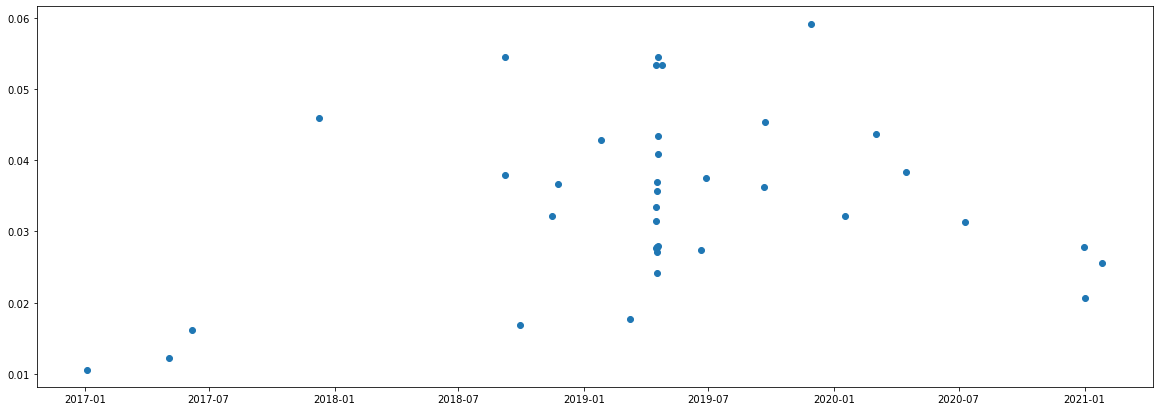

In [36]:
topic_dates = [d for d in df[df['topic_num'] == DISPLAY_TOPIC_NUM]['date_time']]

topic_y = []
for i in list(df.index[df['topic_num'] == DISPLAY_TOPIC_NUM]):
    topic_y.append(y[i])

fig = plt.figure(figsize=(20,7))
plt.scatter(topic_dates, topic_y)
plt.show()

In [38]:
# IMPORTANT: choose which cluster to display
DISPLAY_TOPIC_NUM = 6

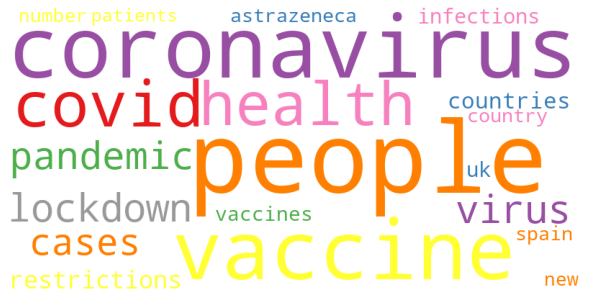

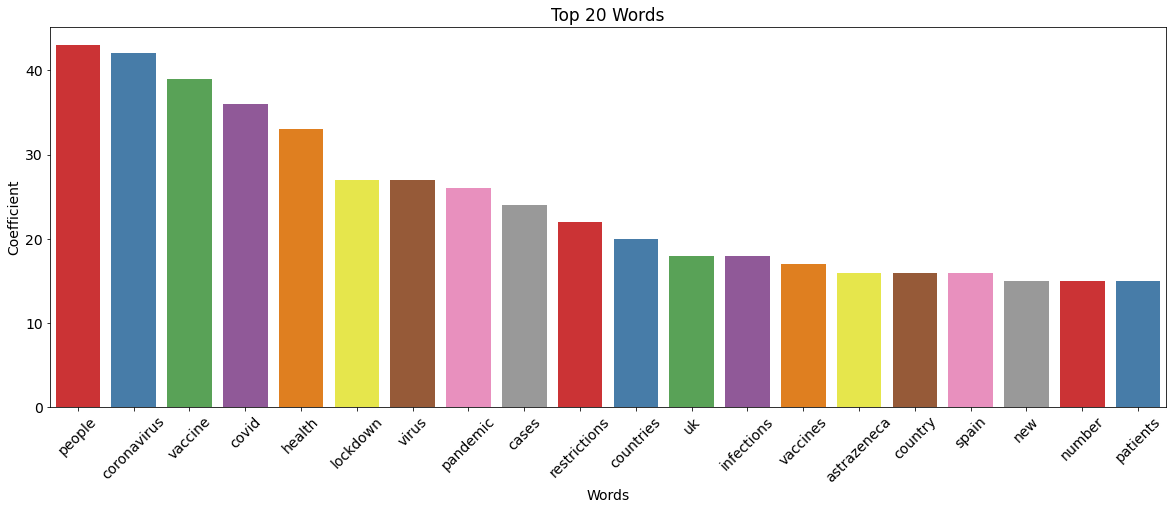

In [39]:
# Display wordcloud and word chart for the topics with best residual

word_dict = {}
for topic_idx, topic in enumerate(nmf.components_):
    word_dict[topic_idx] = {tfidf_fn[i]:int(100*topic[i]) for i in topic.argsort()[:-N_TOP_WORDS - 1:-1]}

for topic_num in [DISPLAY_TOPIC_NUM]:
    wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white', colormap = 'Set1',
                min_font_size = 10).generate_from_frequencies(word_dict[topic_num])
  
    # plot the WordCloud image                       
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
  
    plt.show()
    
    df_gr = pd.DataFrame.from_dict({"word":list(word_dict[topic_num].keys()), "coefficient":list(word_dict[topic_num].values())})
    # Plot a bar chart for the top 20 most frequently occuring words
    fig = plt.figure(figsize=(20,7))

    g = sns.barplot(
        x='word',
        y='coefficient',
        data=df_gr,
        palette='Set1'
    )

    g.set_xticklabels(
        g.get_xticklabels(),
        rotation=45,
        fontsize=14
    )

    plt.yticks(fontsize=14)
    plt.xlabel('Words', fontsize=14)
    plt.ylabel('Coefficient', fontsize=14)
    plt.title('Top 20 Words', fontsize=17)

    plt.show()

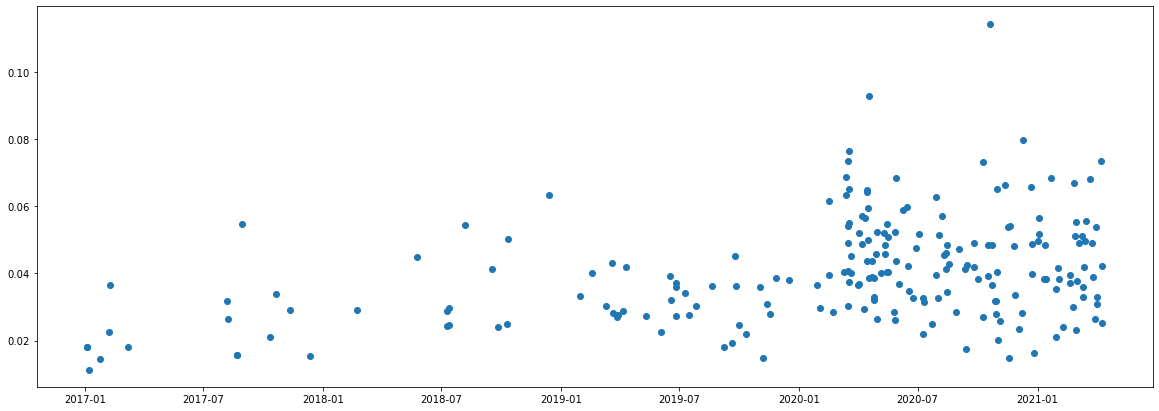

In [40]:
topic_dates = [d for d in df[df['topic_num'] == DISPLAY_TOPIC_NUM]['date_time']]

topic_y = []
for i in list(df.index[df['topic_num'] == DISPLAY_TOPIC_NUM]):
    topic_y.append(y[i])

fig = plt.figure(figsize=(20,7))
plt.scatter(topic_dates, topic_y)
plt.show()